In [1]:
import os
import yaml

import matplotlib.pyplot as plt
import numpy as np
from corner import corner

from mejiro.utils import util

# read configuration file
import mejiro
# config_file = os.path.join(os.path.dirname(mejiro.__file__), 'data', 'mejiro_config', 'all.yaml')  # TODO don't forget to update this!
config_file = '/grad/bwedig/mejiro/projects/nancy/nancy.yaml'
with open(config_file, 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

if config['dev']:
    config['pipeline_label'] += '_dev'

In [2]:
total = config['survey']['total_population']

In [3]:
data_dir = os.path.join(config['data_dir'], config['pipeline_label'], '01')

detectable_csv = os.path.join(data_dir, 'detectable_pop.csv')
detectable_df = util.combine_all_csvs(data_dir, 'detectable_pop_', detectable_csv)

if total:
    total_csv = os.path.join(data_dir, 'total_pop.csv')
    total_df = util.combine_all_csvs(data_dir, 'total_pop_', total_csv)

Wrote combined CSV to /nfsdata1/bwedig/mejiro/nancy_dev/01/detectable_pop.csv
Wrote combined CSV to /nfsdata1/bwedig/mejiro/nancy_dev/01/total_pop.csv


In [4]:
survey_area = config['survey']['area']
runs = config['survey']['runs']
total_area = survey_area * runs
print(f'{runs} run(s) of {survey_area} sq. deg. each gives {total_area:.2f} sq. deg. total')

print(f'{len(detectable_df)} detectable strong lenses')

det_per_sq_deg = len(detectable_df) / total_area
print(f'Detectable strong lenses per sq. deg.: {det_per_sq_deg:.2f}')

det_per_exposure = det_per_sq_deg * 0.281
print(f'Detectable strong lenses per exposure: {det_per_exposure:.2f}')

snr_threshold = 200
high_snr_df = detectable_df[detectable_df['snr'] > snr_threshold]
high_snr_det_per_sq_deg = len(high_snr_df) / total_area
# high_snr_det_per_exposure = high_snr_det_per_sq_deg * 0.281

print(f'{len(high_snr_df)} characterizable strong lenses (SNR > {snr_threshold})')
print(f'{high_snr_det_per_sq_deg:.2f} characterizable per sq. deg.')
# print(f'Characterizable strong lenses per exposure: {high_snr_det_per_exposure:.2f}')

128 run(s) of 0.5 sq. deg. each gives 64.00 sq. deg. total
606 detectable strong lenses
Detectable strong lenses per sq. deg.: 9.47
Detectable strong lenses per exposure: 2.66
0 characterizable strong lenses (SNR > 200)
0.00 characterizable per sq. deg.


In [5]:
band = 'F146'  # F129, J, F115W

mass_col = 'm_star'
mass_label = r"$\log(M_{*})$"
if 'main_halo_mass' in detectable_df.columns:
    mass_col = 'main_halo_mass'
    mass_label = r"$\log(M_{\rm halo})$"

labels = [
    r"$\sigma_v$",
    mass_label,
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
    "SNR"
]

detectable_sample, total_sample = [], []

for i, row in detectable_df.iterrows():
    detectable_sample.append([
        row['vel_disp'],
        np.log10(row[mass_col]),
        row['theta_e'],
        row['z_lens'],
        row['z_source'],
        row[f'mag_{band}_source'],
        row[f'mag_{band}_lens'],
        row['snr']
    ])

if total:
    for i, row in total_df.iterrows():
        total_sample.append([
            row['vel_disp'],
            np.log10(row[mass_col]),
            row['theta_e'],
            row['z_lens'],
            row['z_source'],
            row[f'mag_{band}_source'],
            row[f'mag_{band}_lens'],
            row['snr']
        ])

In [6]:
print(f"z_lens: min={detectable_df['z_lens'].min():.3f}, max={detectable_df['z_lens'].max():.3f}")
print(f"z_source: min={detectable_df['z_source'].min():.3f}, max={detectable_df['z_source'].max():.3f}")
print(f"mag_{band}_lens: min={detectable_df[f'mag_{band}_lens'].min():.3f}, max={detectable_df[f'mag_{band}_lens'].max():.3f}")
print(f"mag_{band}_source_magnified: min={detectable_df[f'mag_{band}_source_magnified'].min():.3f}, max={detectable_df[f'mag_{band}_source_magnified'].max():.3f}")
print(f"mag_{band}_source: min={detectable_df[f'mag_{band}_source'].min():.3f}, max={detectable_df[f'mag_{band}_source'].max():.3f}")

z_lens: min=0.059, max=2.175
z_source: min=0.477, max=5.621
mag_F146_lens: min=13.651, max=24.277
mag_F146_source_magnified: min=18.701, max=22.950
mag_F146_source: min=20.301, max=25.999


In [7]:
def weights(data):
    return 1 / len(data) * np.ones(len(data))

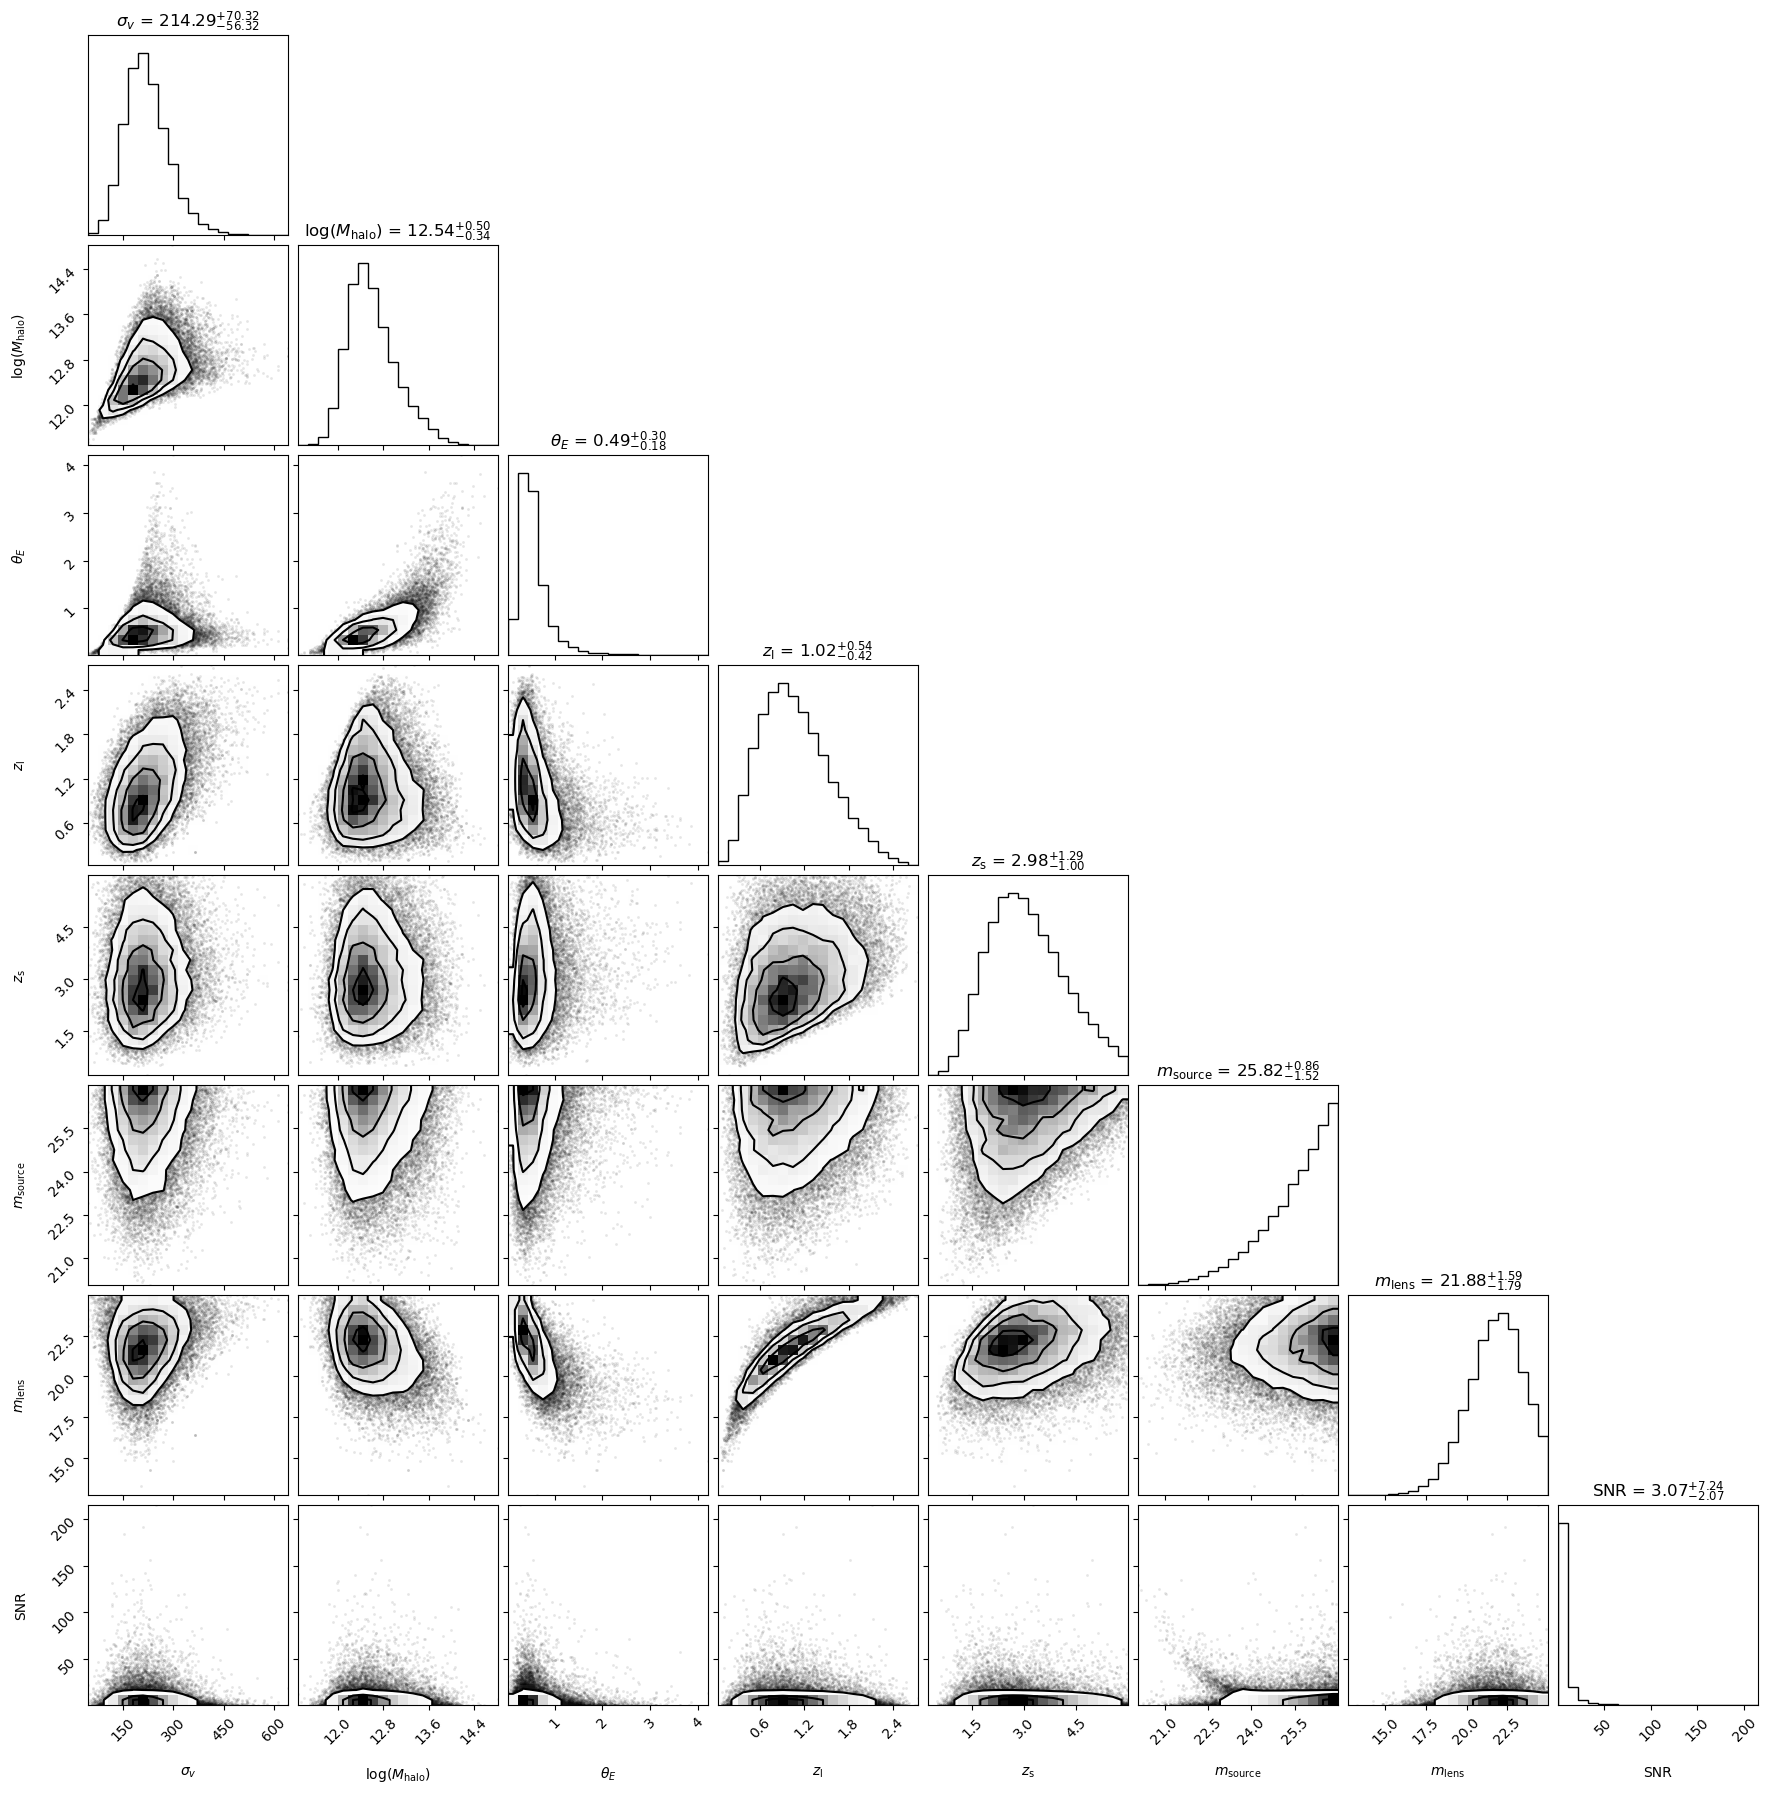

In [8]:
corner_kwargs = {}

if total:
    total_corner = corner(np.array(total_sample), labels=labels, show_titles=True, weights=weights(total_sample))
    corner_kwargs['fig'] = total_corner

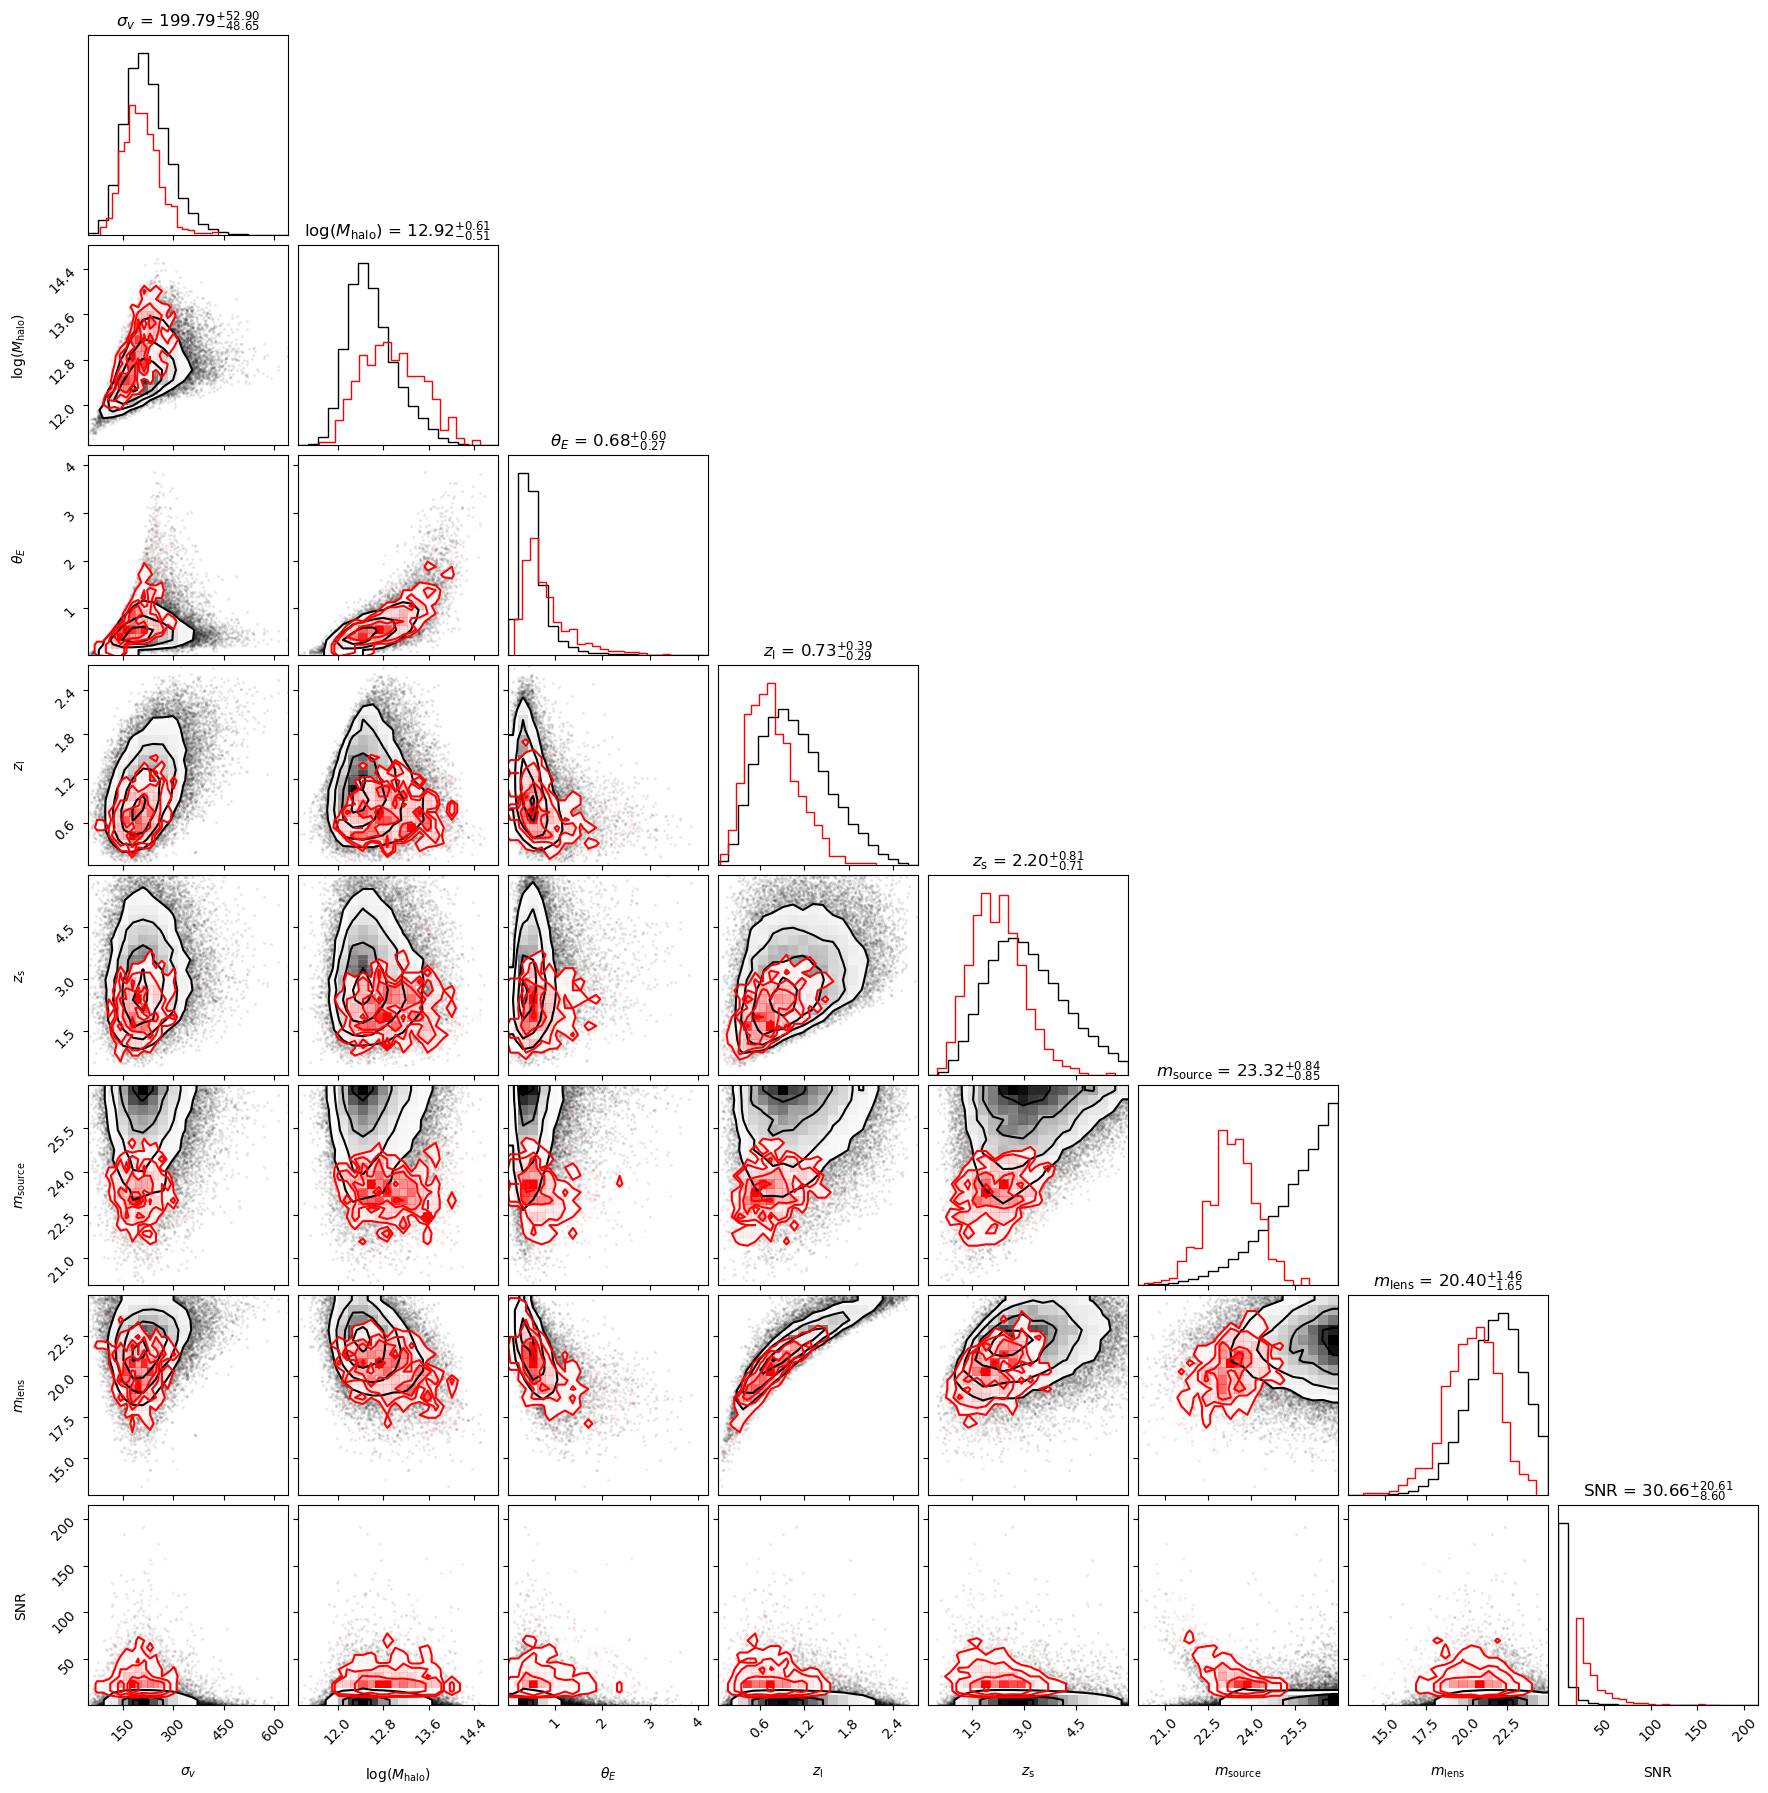

In [9]:
corner(np.array(detectable_sample), color='red', labels=labels, show_titles=True, density=True, weights=weights(detectable_sample), **corner_kwargs)

# corner(np.array(detectable_sample), color='black', labels=labels, show_titles=False, density=True, weights=weights(detectable_sample), label_kwargs={'fontsize': 36}, title_kwargs={'fontsize': 36})

In [10]:
# bands = ['B', 'FUV', 'H', 'I', 'J', 'K', 'NUV', 'R', 'U', 'V']
# plt.figure(figsize=(12, 8))

# for b in bands:
#     plt.hist(detectable_df[f'mag_{b}_source'], bins=50, alpha=0.5, label=b)

# plt.xlabel('Magnitude')
# plt.ylabel('Count')
# plt.title('Histogram of Source Magnitudes for Different Bands')
# plt.legend()
# plt.show()

In [11]:
# snr = detectable_df['snr'].dropna()

# plt.figure(figsize=(8, 5))
# n, bins, patches = plt.hist(snr, bins=50, color='C0', alpha=0.8)
# plt.xlabel('SNR')
# plt.ylabel('Count')
# plt.title('SNR Distribution for Detectable Strong Lenses in NANCY (0.31%)')

# ymax = n.max()
# vlines = [50, 75, 100]
# x_range = snr.max() - snr.min()
# x_offset = x_range * 0.01 if x_range > 0 else 0.1

# for i, v in enumerate(vlines):
#     cnt = int((snr > v).sum())
#     color = f'C{2 + i}'
#     plt.axvline(v, color=color, linestyle='--', linewidth=1.5)
#     ypos = ymax * (0.95 - i * 0.08)  # stagger labels to avoid overlap
#     plt.text(v + x_offset, ypos, f'>{v}: {cnt}', color=color, fontsize=10, fontweight='bold', va='top')

# plt.ylim(0, ymax * 1.05)
# plt.show()